# Discontinuous Hamiltonian Monte Carlo

In [28]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append((os.path.abspath('../')))
import matplotlib.pyplot as plt
import random
import operator
import jax
import jax.numpy as np
from jax import tree_util
import symppl
from numpyro import distributions
import tqdm
from tqdm.notebook import tqdm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
target_dist = distributions.MultivariateNormal(
    np.zeros(2), np.array([[1, 0.98], 
                           [0.98, 1.]]))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

In [30]:
X, Y = np.meshgrid(np.linspace(-3, 3, 100), 
                   np.linspace(-3, 3, 100), 
                  )
_X = np.stack([X, Y]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(_X.T).reshape((100, 100)))

In [31]:
import functools
from dhmc import mcmc, utils, hmc

In [32]:
def kernel(state_):
    state, rng = state_
    rng, rng_step = jax.random.split(rng)
    next_state = hmc.hamiltonian_monte_carlo_step(
        rng_step, 
        target_log_prob_fn,
        state,
        path_length=0.25*20,
        step_size=0.25,
    )
    return (next_state, rng), next_state

state = np.array([1.,1.])

rng = jax.random.PRNGKey(42)
_, samples = utils.trace(
    (state, rng),
    kernel,
    400
)
hmc_samples = samples

In [33]:
# Consider metropolis hasting

In [34]:
def kernel(state_):
    state, rng = state_

    proposal_fn = functools.partial(
        mcmc.random_walk_proposal_fn, scale=0.18)
    rng, rng_step = jax.random.split(rng)
    next_state = mcmc.random_walk_metropolis_hasting_step(
        rng_step, 
        state,
        target_log_prob_fn,
        proposal_fn=proposal_fn
    )
    return (next_state, rng), next_state

state = np.array([1.,1.])

rng = jax.random.PRNGKey(42)
_, samples = utils.trace(
    (state, rng),
    kernel,
    400*20
)

mh_samples = samples[::20]

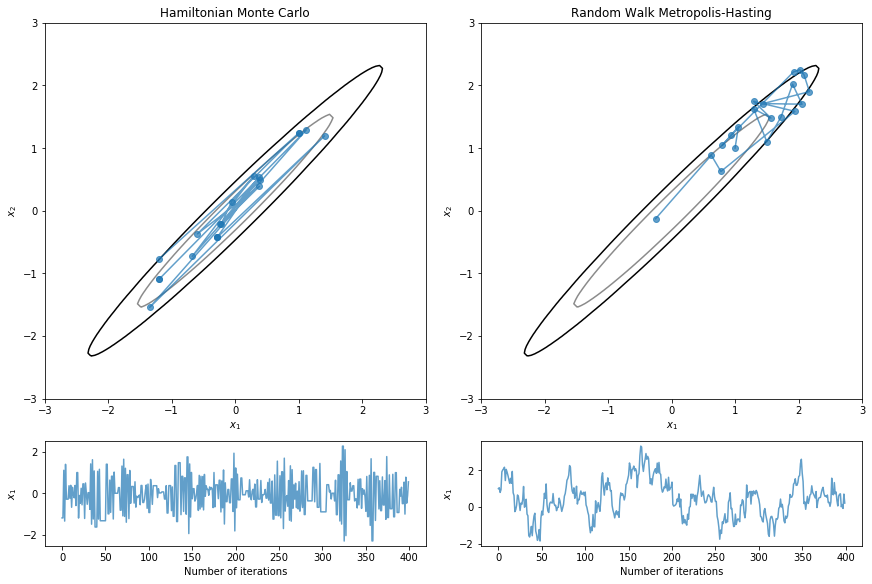

In [40]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 8), constrained_layout=True)

spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax = fig.add_subplot(spec[:2, 0])
ax.contour(X, Y, probs, 
           levels=[0.3989422804014327, 0.2419, 0.05399][::-1],
           cmap='binary_r')
ax.plot(hmc_samples[:20, 0], hmc_samples[:20,1], 'C0o-', alpha=.7, 
        label='Hamiltonian Monte Carlo');
ax.set(title='Hamiltonian Monte Carlo')
ax.set(xlabel='$x_1$', ylabel='$x_2$')
ax = fig.add_subplot(spec[2, 0])
ax.plot(hmc_samples[:,0], label='x', alpha=0.7)
ax.set(xlabel='Number of iterations', ylabel='$x_1$')

# MH

ax = fig.add_subplot(spec[:2, 1])
ax.contour(X, Y, probs, 
           levels=[0.3989422804014327, 0.2419, 0.05399][::-1],
           cmap='binary_r')
ax.plot(mh_samples[:20, 0], mh_samples[:20, 1], 'C0o-', 
             alpha=.7, label='Random Walk Metropolis-Hasting')
# ax.legend()
ax.set(title='Random Walk Metropolis-Hasting')
ax.set(xlabel='$x_1$', ylabel='$x_2$')

ax = fig.add_subplot(spec[2, 1])
ax.plot(mh_samples[:,0], label='x', alpha=0.7);
ax.set(xlabel='Number of iterations', ylabel='$x_1$')

fig.savefig('../figures/hmc_mh_comparison.pdf', transparent=True)

In [36]:
# Visualize HMC Hamiltonian conservation
from symppl.infer import hmc
# from symppl.infer import mcmc, utils
from jax import random

rng = jax.random.PRNGKey(0)
current_state = np.array([-1.50, -1.55])
p = np.array([-1. ,1.])

def target_log_prob_fn(state):
    Sinv = np.linalg.inv(
        np.array([[1, 0.95], 
                  [0.95, 1.]]))
    return -np.dot(state, np.dot(Sinv, state)) / 2

logprob, state_grads = utils.call_fn_value_and_grad(target_log_prob_fn, 
                                                current_state)
state = hmc.IntegratorState(current_state, 
                            state_grads, 
                            logprob,
                            p)

ke = hmc.gaussian_kinetic_energy_fn(p)

num_steps = 25
step_size = 0.25
states = [state]
kes = [ke]
for _ in range(num_steps):
    rng, rng_step = random.split(rng)
    state = hmc.leapfrog_step(state,
                              target_log_prob_fn,
                              hmc.gaussian_kinetic_energy_fn,
                              step_size=step_size,
                              rng=rng_step)
    kes.append(hmc.gaussian_kinetic_energy_fn(state.momentum))
    states.append(state)

In [37]:
U = - np.stack([s.target_log_prob for s in states])
K = np.stack(kes)
H = - np.stack([s.target_log_prob for s in states]) + np.stack(kes)

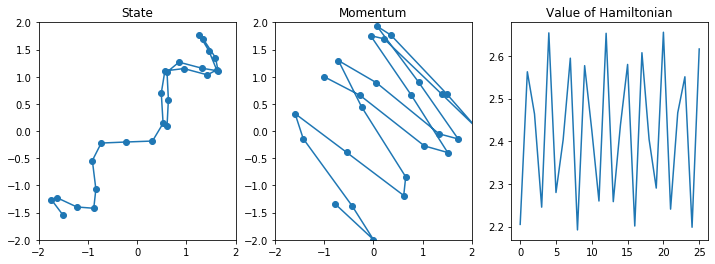

In [47]:
samples = np.array([s.state for s in states])
momentums = np.array([s.momentum for s in states])

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].plot(samples[:,0], samples[:,1], 'C0o-')
ax[0].set(xlim=(-2,2), ylim=(-2,2), title='State')

ax[1].plot(momentums[:,0], momentums[:,1], 'C0o-')
ax[1].set(xlim=(-2,2), ylim=(-2,2), title='Momentum')

ax[2].plot(H);
ax[2].set(title='Value of Hamiltonian');
fig.savefig('../figures/hmc_progress.pdf', transparent=True)

# Discontinuous Hamiltonian Monte Carlo

We next investigate the issues with discontinuities in the logjoint 

In [48]:
As = []
D = 2
for i in range(D):
    if i % 2 == 0:
        As.append(1)
    else:
        As.append(np.exp(-1.))
A = np.diag(np.array(As))

def target_log_prob_fn(*x):
    x = np.stack(x)
    norm = np.max(np.abs(x), axis=-1)
    if norm <= 3:
        out = -np.sqrt(np.dot(x, np.dot(A,x)))
    elif norm <= 6 and norm > 3:
        out = -np.sqrt(np.dot(x, np.dot(A,x)))-1
    else:
        out = -np.array(np.inf)
    return out

We first start by visualizing the potential function

Let's first simulate with HMC

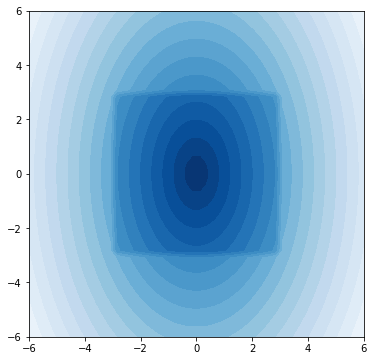

In [70]:
RESOLUTION = 50
X, Y = np.meshgrid(np.linspace(-6, 6, RESOLUTION),
                   np.linspace(-6, 6, RESOLUTION)
                  )
probs = []
for x, y in zip(X.reshape(-1), Y.reshape(-1)):
    probs.append(target_log_prob_fn(x, y))
probs = np.stack(probs).reshape((RESOLUTION, RESOLUTION))
probs = probs
fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(X, Y, probs, levels=20, cmap='Blues');

Next we look at DHMC

In [71]:
from dhmc import dhmc
rng = jax.random.PRNGKey(0)
current_state = [np.array(1.), np.array(2.)]
p = [np.array(3.), np.array(2.)]
kinetic_energy_fn = dhmc.gauss_laplace_kinetic_energy_fn

logprob, state_grads = utils.call_fn_value_and_grad(target_log_prob_fn,
                                                    current_state)
state = hmc.IntegratorState(current_state, 
                            state_grads, 
                            logprob,
                            p)

ke = dhmc.gauss_laplace_kinetic_energy_fn(*state.momentum, n_disc=2)
num_steps = 200
step_size = 0.25
states = [state]
kes = [ke]
for _ in range(num_steps):
    rng, rng_step = random.split(rng)
    state = dhmc.gauss_laplace_leapfrog(state,
                              target_log_prob_fn,
                              kinetic_energy_fn,
                              step_size=step_size,
                              rng=rng_step, n_disc=2)

    kes.append(
        dhmc.gauss_laplace_kinetic_energy_fn(*state.momentum, n_disc=2)
    )
    states.append(state)

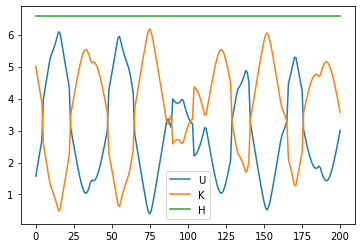

In [72]:
fig, ax = plt.subplots()
U = - np.stack([s.target_log_prob for s in states])
K = np.stack(kes)
H = - np.stack([s.target_log_prob for s in states]) + np.stack(kes)
# plt.plot(H)
ax.plot(U, label='U')
ax.plot(K, label='K')
ax.plot(H, label='H')
plt.legend()

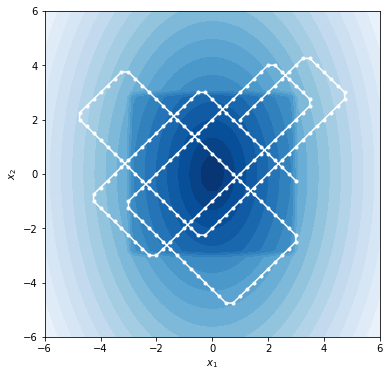

In [73]:
xy = np.stack([np.stack(s.state) for s in states])

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(X, Y, probs, levels=20, cmap='Blues');
ax.plot(xy[:, 0], xy[:,1], 
        'wo-', 
        markersize=3.)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
fig.savefig('../figures/dhmc.pdf', transparent=True);

In [76]:
rng = jax.random.PRNGKey(0)
current_state = [np.array(1.), np.array(2.)]
p = [np.array(2.), np.array(1.)]


logprob, state_grads = utils.call_fn_value_and_grad(target_log_prob_fn,
                                                    current_state)
integrator_state = hmc.IntegratorState(current_state, 
                            state_grads, 
                            logprob,
                            p)

ke = hmc.gaussian_kinetic_energy_fn(*integrator_state.momentum)

num_steps = 100
step_size = 0.25
states = [state]
kes = [ke]
for _ in range(num_steps):
    rng, rng_step = random.split(rng)
    state = hmc.leapfrog_step(state,
                              target_log_prob_fn,
                              hmc.gaussian_kinetic_energy_fn,
                              step_size=step_size,
                              rng=rng_step)
    kes.append(hmc.gaussian_kinetic_energy_fn(*state.momentum))
    states.append(state)

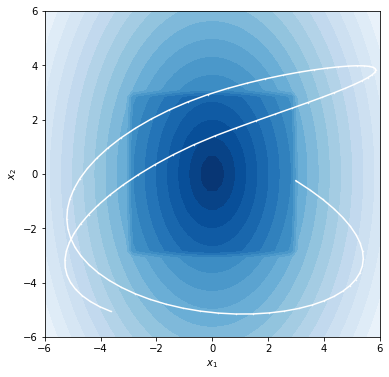

In [77]:
xy = np.stack([np.stack(s.state) for s in states])

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(X, Y, probs, levels=20, cmap='Blues');
ax.plot(xy[:, 0], xy[:,1], 'wo-', markersize=.5)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
ax.set(xlim=(-6,6), ylim=(-6,6))
ax.set(xlabel='$x_1$', ylabel='$x_2$')
fig.savefig('../figures/hmc.pdf', transparent=True);

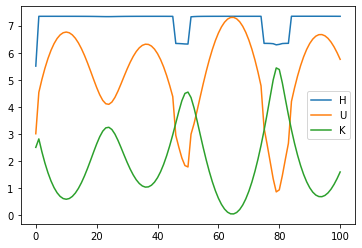

In [78]:
U = - np.stack([s.target_log_prob for s in states])
K = np.stack(kes)
H = - np.stack([s.target_log_prob for s in states]) + np.stack(kes)
plt.plot(H, label='H')
plt.plot(U, label='U')
plt.plot(K, label='K')
plt.legend()